# Tercer modelo

Support vector regression utilizando como predictores únicamente los datos propios del Índice IBEX 35. Este índice integra las cotizaciones de las 35 empresas más importantes de España. Es un índice ponderado según la capitalización bursatil de las 35 empresas que lo componen; es decir, las empresas que tienen una mayor capitalización tiene más peso en el índice.
El dataset con el que trabajaremos dispone de las siguientes variables:
- fecha, día de la muestra
- último, valor de cierre del índice expresado en puntos para ese día (unidad puntos)
- apertura, valor de apertura del índice expresado en puntos para ese día
- máximo, valor máximo alcanzado del índice expresado en puntos para ese día
- mínimo, valor mínimo alcanzado del índice expresado en puntos para ese día
- volumen, número de operaciones de compraventa cerradas para ese día (unidad millones)
- variación, variación del valor del índice con respecto al día anterior (unidad %)
- deuda_publica, conjunto de deudas que mantiene el Estado español frente a los particulares que pueden ser españoles o de otro país
- ipc, indicador que mide la variación de los precios de una cesta de bienes y servicios en un lugar concreto durante un determinado periodo de tiempo
- tasa_paro, mide el nivel de desocupación en relación con la población activa
- pib, suma de todos los bienes y servicios finales que produce un país o una economía, elaborados dentro del territorio nacional tanto por empresas nacionales como extranjeras, y que se registran en un periodo determinado

La variable a predecir:  
- el valor último o de cierre

En esta primera prueba vamos a utilizar el dataset con los datos desde el 12-02-2015. Se filtra por esta fecha porque viene marcado por el dataset de AENA que sólo tiene datos desde esa fecha. Además las variables exogenas que utilizamos no tienen datos desde el año 1991.

## Carga de las librerías y datos

In [1]:
import numpy as np
import pandas as pd
import pandas as pdBb
import glob
import datetime
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import metrics
# Para ajuste de escalas
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Cargamos los datos de entrada
data = pd.read_csv("./dataset/IBEX35/final_historic_data_with_metrics_IBEX35_filter_by_20150212.csv")
data.shape

(1423, 11)

## Análisis exploratorio de los datos y relación entre variables

Visualizamos una pequeña muestra del dataset:

In [3]:
data.head(-10)

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
0,2015-02-12,"10.562,20","10.349,60","10.607,10","10.328,50","328,00M","1,90%","1.044.720,44","-1,07","23,78","1,15"
1,2015-02-13,"10.739,50","10.618,50","10.794,90","10.606,70","427,94M","1,68%","1.044.720,44","-1,07","23,78","1,15"
2,2015-02-16,"10.689,50","10.717,80","10.793,10","10.679,90","220,58M","-0,47%","1.044.720,44","-1,07","23,78","1,15"
3,2015-02-17,"10.698,00","10.591,60","10.730,10","10.526,60","272,47M","0,08%","1.044.720,44","-1,07","23,78","1,15"
4,2015-02-18,"10.805,30","10.764,60","10.852,60","10.764,10","298,37M","1,00%","1.044.720,44","-1,07","23,78","1,15"
...,...,...,...,...,...,...,...,...,...,...,...
1408,2020-08-17,"7.090,10","7.141,50","7.173,30","7.064,10","131,24M","-0,90%","1.257.818,96","-0,60","15,33","-18,50"
1409,2020-08-18,"7.043,50","7.065,70","7.165,60","7.024,40","142,78M","-0,66%","1.257.818,96","-0,60","15,33","-18,50"
1410,2020-08-19,"7.094,30","7.039,10","7.094,30","7.002,80","132,23M","0,72%","1.257.818,96","-0,60","15,33","-18,50"
1411,2020-08-20,"6.993,30","7.011,40","7.034,50","6.974,90","155,67M","-1,42%","1.257.818,96","-0,60","15,33","-18,50"


Vemos los tipos de las columnas para ver si sería conveniente realizar algún tipo de transformación:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423 entries, 0 to 1422
Data columns (total 11 columns):
fecha            1423 non-null object
ultimo           1423 non-null object
apertura         1423 non-null object
maximo           1423 non-null object
minimo           1423 non-null object
vol              1421 non-null object
variacion        1423 non-null object
deuda_publica    1423 non-null object
ipc              1423 non-null object
tasa_paro        1423 non-null object
pib              1423 non-null object
dtypes: object(11)
memory usage: 122.4+ KB


Y obtenemos algunos estadísticos:

In [5]:
data.describe()

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
count,1423,1423,1423,1423,1423,1421,1423,1423,1423,1423,1423
unique,1423,1396,1399,1392,1388,1375,472,64,62,22,19
top,2019-07-04,"10.245,80","9.112,90","9.436,10","8.531,80","208,11M","0,21%","1.234.693,96","-0,60","15,33","0,55"
freq,1,2,2,2,2,3,14,61,48,109,128


Una vez analizada la información vemos que si sería conveniente realizar una serie de transformaciones en los datos:
- Cambiar el formato de miles y decimales de todas las columnas
- En el campo volumen existen dos tipos de unidades (M millones) y (B billones)
    + (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
    + (B billones) vamos a quitar la unidad y multiplicamos por 1000
- En el campo variación se va a quitar el %
- Quitaremos la columna fecha
- Rellenamos los valores nulos utilizando el método "forward fill" de forma que los valores no nulos se copien hacia adelante siempre que se encuentren valores nulos
- Convertir los NaN a 0
- Convertir las columnas a float

In [6]:
# Vamos a aplicar una serie de transformaciones a los datos
# Cambiamos el formato de miles y decimales de todas las columnas
data = data.replace(r'[.]','', regex=True)
data = data.replace(r'[,]','.', regex=True)
# Volumen: existen dos tipos de unidades (M millones) y (B billones)
# Se harán dos transformaciones:
# - (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
# - (B billones) vamos a quitar la unidad y multiplicamos por 1000
transform = {'B': 10**3, 'M': 1}
def convert_cash(item):
    try:
        item_transform = item[-1]
        return float(item[:-1]) * transform[item_transform]
    except TypeError:
        return item
data['vol'] = data['vol'].map(lambda x: convert_cash(x) if (pd.notnull(x)) else x)   
# Variación: vamos a quitar el % aunque no haremos la transformación en los datos 
data['variacion'] = data['variacion'].map(lambda x: x.rstrip('%') if (pd.notnull(x)) else x)
# Quitamos la columna fecha
data = data.drop(['fecha'], axis=1)
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos en las columnas: deuda_publica, ipc, tasa_paro y pib
data['deuda_publica'].fillna(method='ffill', inplace=True)
data['ipc'].fillna(method='ffill', inplace=True)
data['tasa_paro'].fillna(method='ffill', inplace=True)
data['pib'].fillna(method='ffill', inplace=True)
# Convertimos los NaN a 0
data = data.fillna(0)
# Convertimos las columnas a float
data = data.astype({"ultimo": float, "apertura": float, "maximo": float, "minimo": float, "vol": float, 
                    "variacion": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, "pib": float})
data

,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
0,10562.2,10349.6,10607.1,10328.5,328.00,1.90,1044720.44,-1.07,23.78,1.15
1,10739.5,10618.5,10794.9,10606.7,427.94,1.68,1044720.44,-1.07,23.78,1.15
2,10689.5,10717.8,10793.1,10679.9,220.58,-0.47,1044720.44,-1.07,23.78,1.15
3,10698.0,10591.6,10730.1,10526.6,272.47,0.08,1044720.44,-1.07,23.78,1.15
4,10805.3,10764.6,10852.6,10764.1,298.37,1.00,1044720.44,-1.07,23.78,1.15
...,...,...,...,...,...,...,...,...,...,...
1418,6969.5,7174.3,7198.3,6960.0,205.26,-2.29,1257818.96,-0.60,15.33,-18.50
1419,6956.9,7038.5,7042.0,6903.0,226.08,-0.18,1257818.96,-0.60,15.33,-18.50
1420,6996.9,6973.1,7046.1,6963.9,208.51,0.57,1257818.96,-0.60,15.33,-18.50
1421,7006.0,7065.2,7159.6,6971.2,246.67,0.13,1257818.96,-0.60,15.33,-18.50


In [7]:
data.describe()

,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1.423000e+03,1423.000000,1423.000000,1423.000000
mean,9430.044483,9437.229164,9496.720731,9365.211174,223.780738,-0.019895,1.140184e+06,0.656170,17.207280,-1.072706
std,1090.093607,1085.038425,1081.467531,1093.098699,97.876620,1.330446,5.748304e+04,1.110364,2.853543,5.170246
min,6107.200000,6223.700000,6362.500000,5814.500000,0.000000,-14.060000,1.036739e+06,-1.070000,13.780000,-18.500000
25%,8855.000000,8859.200000,8910.600000,8782.250000,153.300000,-0.610000,1.098691e+06,-0.315000,14.550000,0.430000
50%,9407.900000,9428.400000,9468.900000,9363.800000,203.420000,0.030000,1.139305e+06,0.670000,16.550000,0.550000
75%,10208.150000,10206.950000,10253.650000,10140.950000,275.440000,0.615000,1.187983e+06,1.570000,18.910000,0.750000
max,11866.400000,11798.500000,11884.600000,11760.800000,1080.000000,7.820000,1.257819e+06,2.970000,23.780000,1.150000


A continuación vamos a visualizar una serie de gráficas por cada variable de entrada para visualizar entre qué valores se concentran la mayoría de los registros.

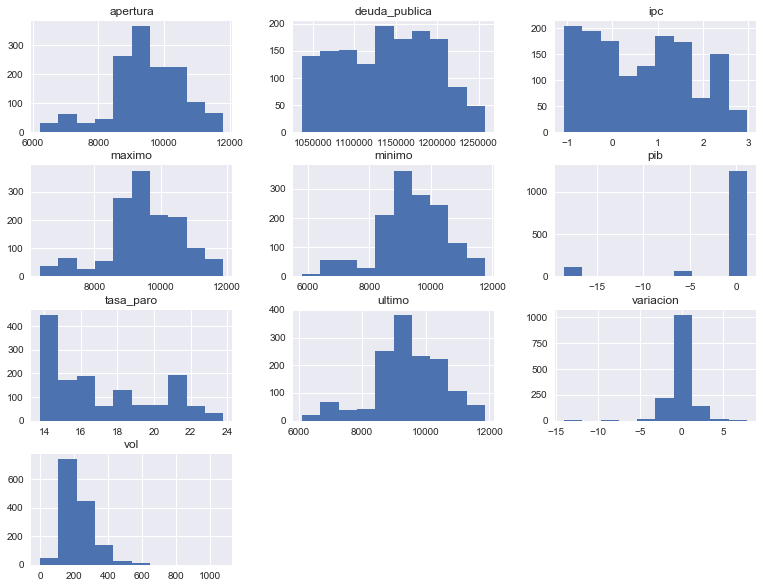

In [8]:
#data.hist(ax=ax)
#plt.show()
fig, ax = plt.subplots(figsize=(13,10))
data.hist(ax=ax)
plt.show()

Realizamos un diagrama de dispersión para analizar los datos con respecto a las variables, ver la distribución de los mismos y analizar de forma rápida si contiene outliers:

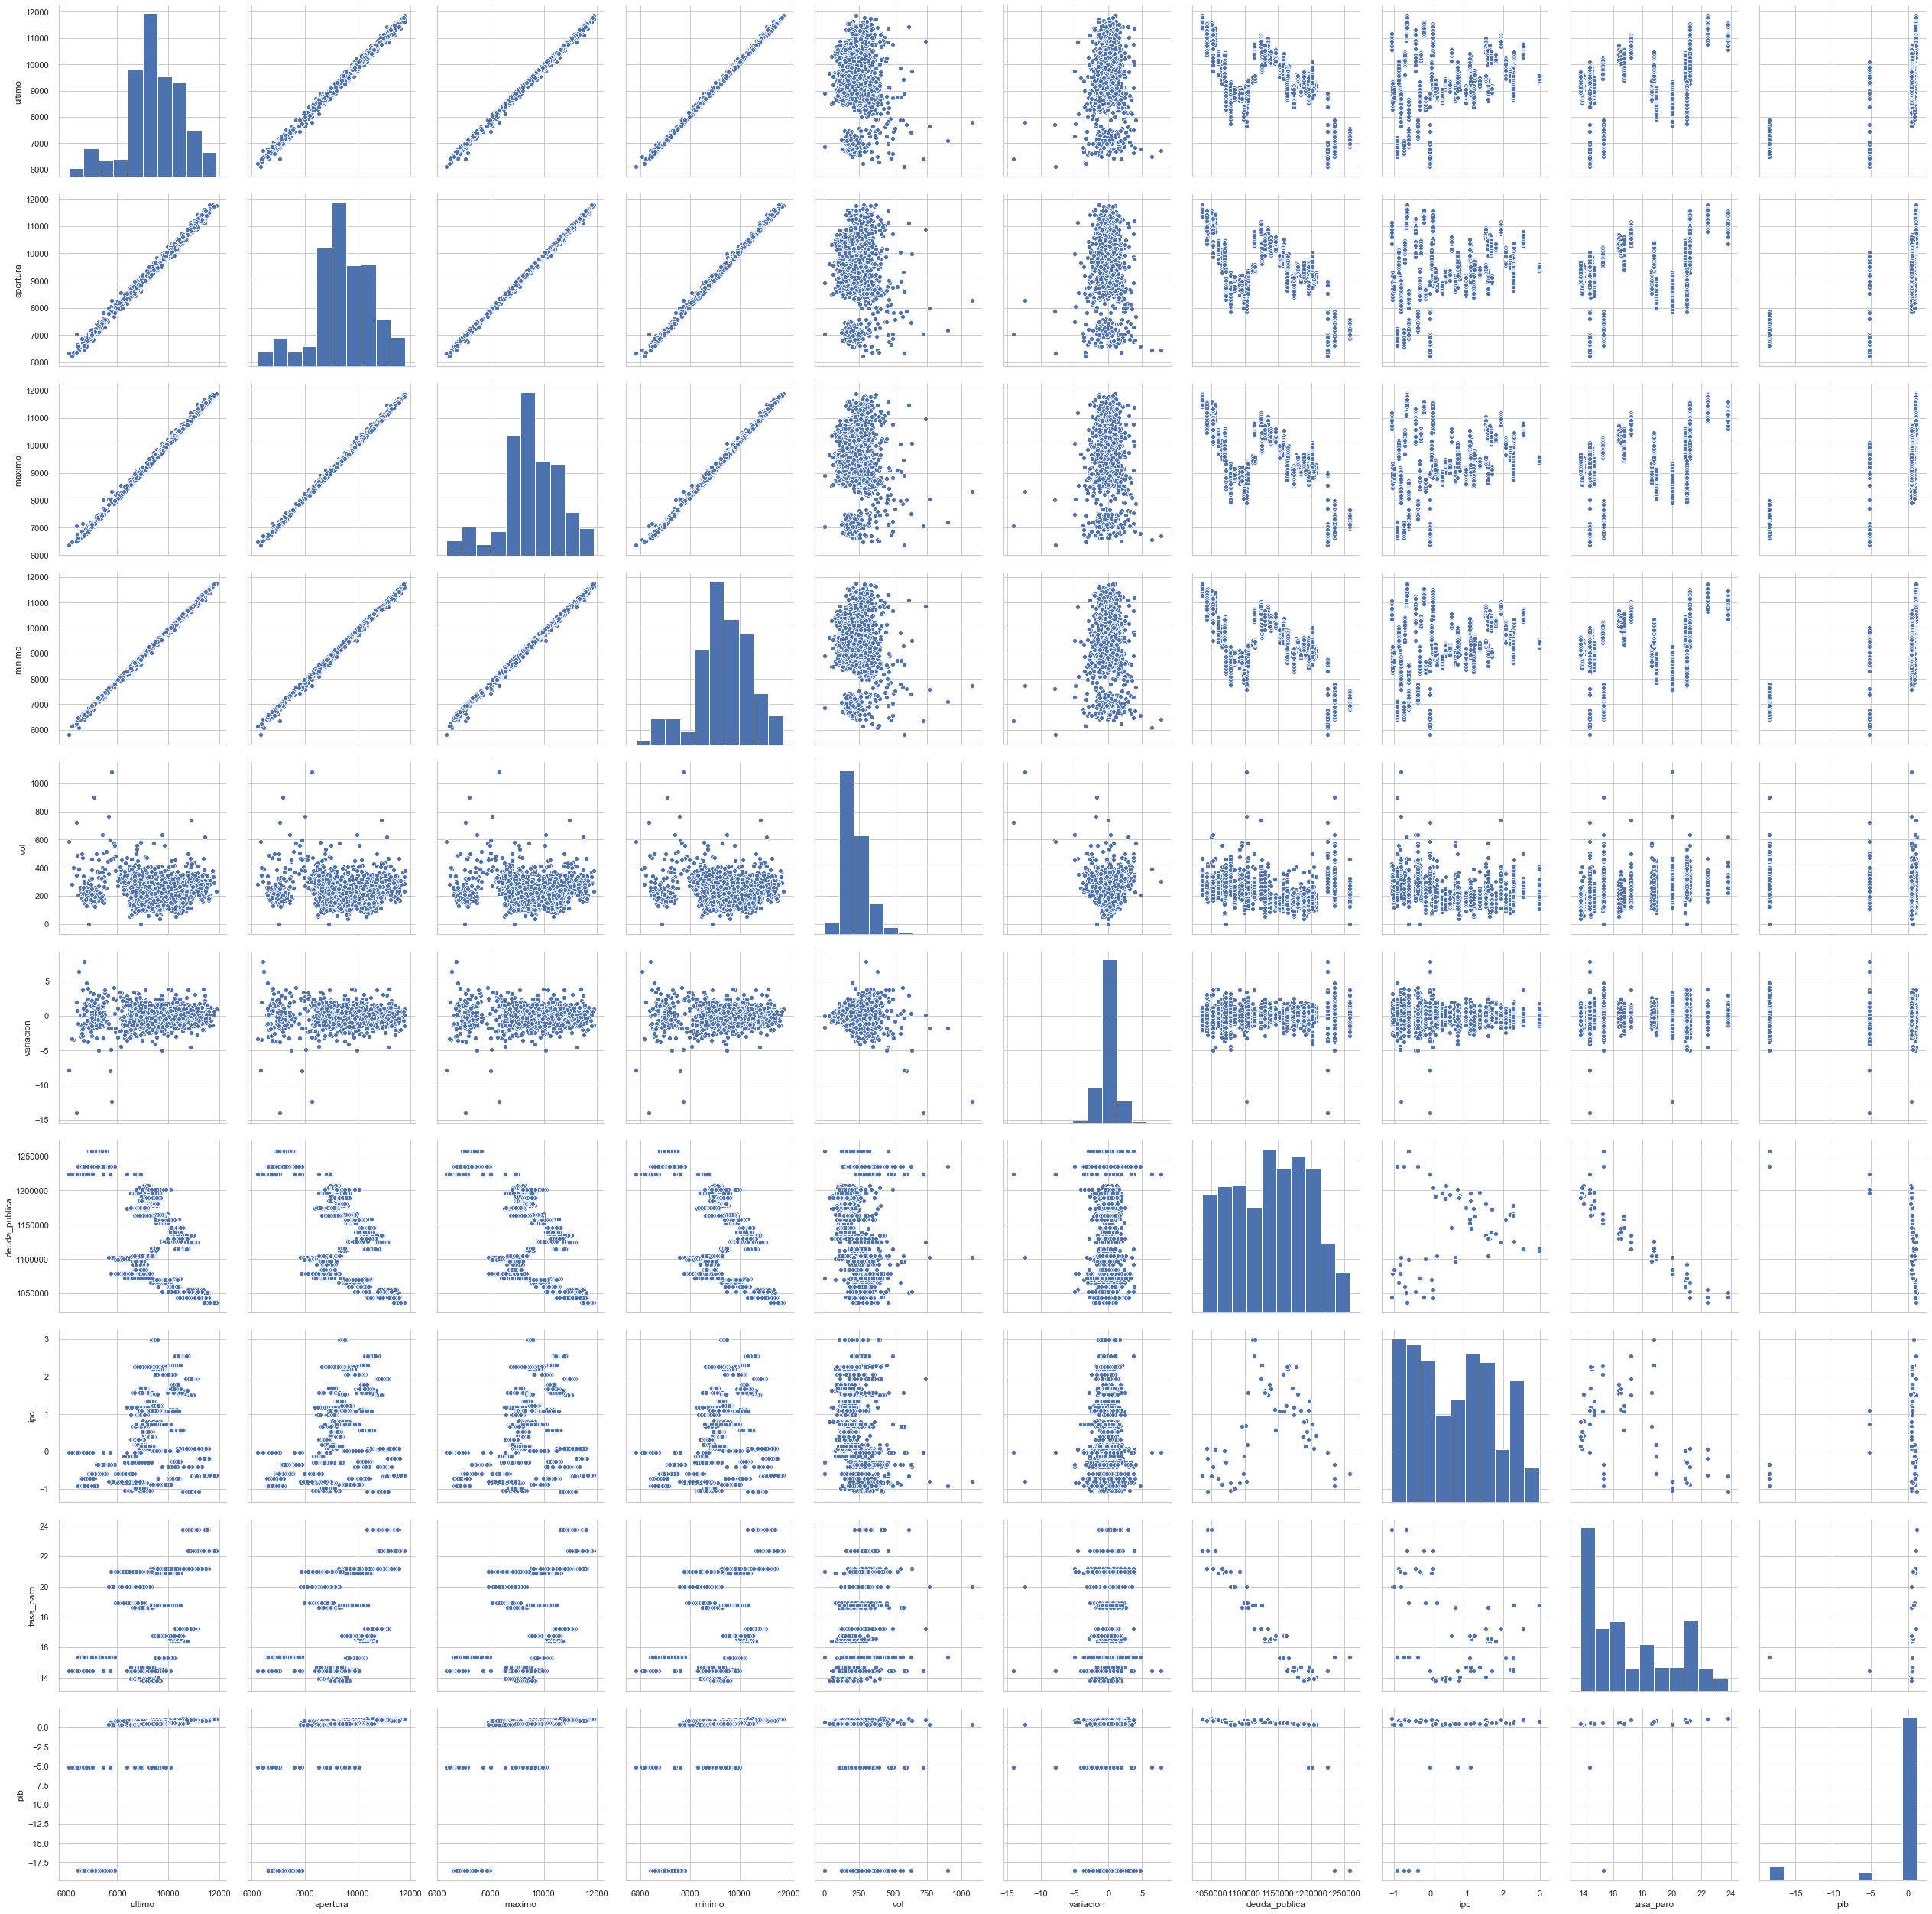

In [9]:
# Scatterplot matrix para mostrar la distribución de los datos
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
sns.pairplot(data, height=3.5)
plt.show()

Y pintamos la matriz de correlación:

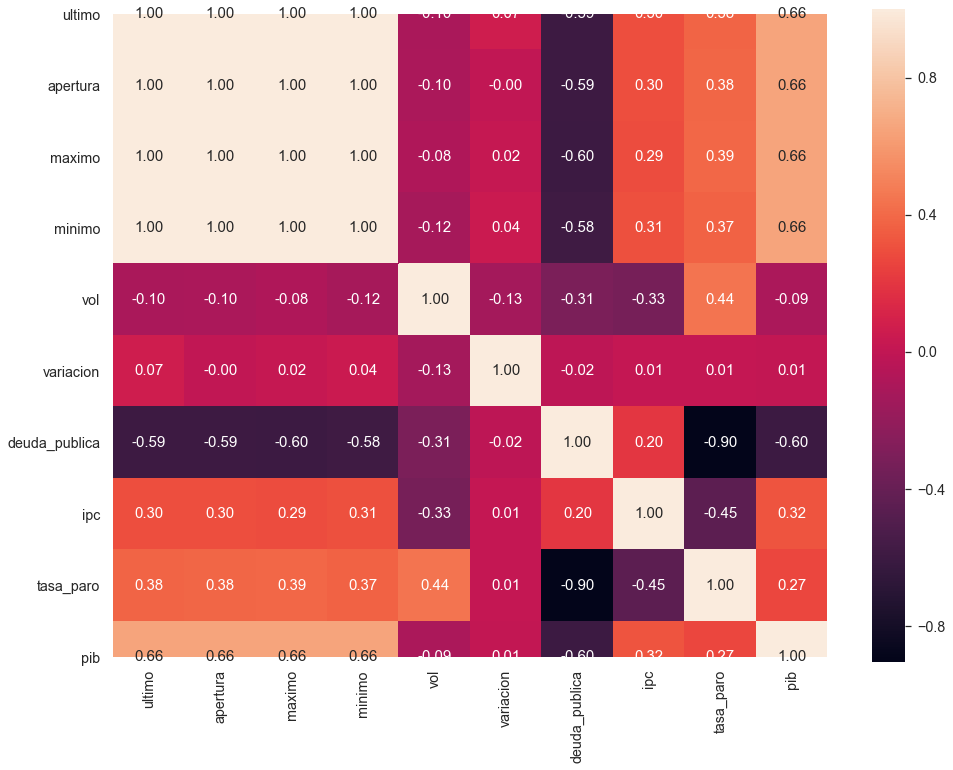

In [10]:
# Mostramos el diagrama de correlación entre los distintos predictores utilizando Seaborn > heatmap
corr_data = np.corrcoef(data.values.T)
sns.set(font_scale=1.3)
plt.subplots(figsize=(16,12))
heatmap_data = sns.heatmap(corr_data,
                          cbar=True,
                          annot=True,
                          square=True,
                          fmt='.2f',
                          annot_kws={'size':15},
                          yticklabels=["ultimo","apertura","maximo","minimo","vol","variacion","deuda_publica","ipc","tasa_paro","pib"],
                          xticklabels=["ultimo","apertura","maximo","minimo","vol","variacion","deuda_publica","ipc","tasa_paro","pib"])
plt.show()

Esta información es crítica a la hora de identificar cuáles pueden ser los mejores predictores para el modelo, qué variables presentan relaciones de tipo no lineal y para identificar colinialidad entre predictores.
De este análisis se pueden extraer las siguientes conclusiones:
- Las variables que tienen una mayor relación lineal con ultimo son: apertura (r=1.00), maximo (r=1.00) y minimo (r=1.00)
- Los predictores apertura, maximo y minimo estan altamente correlacionados (r>=0.99) por lo que no se van a utilizar
- La variable variación como depende directamente de la variable a predecir tampoco se va a incorporar
- Las variables que presenta bastante relación lineal con ultimo son: deuda_publica (r=-0.53), pib (r=0.56), tasa_paro (r=0.39), y en menor medida ipc (r=0.27)

## Selección de los predictores y ajuste de un modelo support vector regression

Creamos trainig y test, donde test únicamente estará formado por 20 registros.

In [11]:
# Definimos las variables de entrada y salida
X = data[["deuda_publica","ipc", "tasa_paro", "pib"]]
y = data.ultimo
# Creamos los datasets de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20)
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (1403, 4) (1403,)
Testing dataset shape: (20, 4) (20,)


Utilizando la técnica GridSearchCV de Sklearn vamos a calcular cuales serían los mejores parámetros "gamma" y "C" utilizados en el modelo SVR() que minimicen el MSE.

In [12]:
cv_params = dict([
        ('gamma', 10.0**np.arange(-4,6)),
        ('C', 10.0**np.arange(-2,4)),
    ])
model = GridSearchCV(SVR(kernel = 'rbf'), cv_params, cv=5, verbose=1, n_jobs=-1, scoring="neg_mean_squared_error")
model.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(model.best_params_)
print("Grid scores on development set:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s


Best parameters set found on development set:
{'C': 1000.0, 'gamma': 1.0}
Grid scores on development set:
-1189877.261 (+/-152614.219) for {'C': 0.01, 'gamma': 0.0001}
-1189878.677 (+/-152614.597) for {'C': 0.01, 'gamma': 0.001}
-1189878.778 (+/-152614.605) for {'C': 0.01, 'gamma': 0.01}
-1189879.774 (+/-152614.686) for {'C': 0.01, 'gamma': 0.1}
-1189888.569 (+/-152615.487) for {'C': 0.01, 'gamma': 1.0}
-1189923.333 (+/-152621.192) for {'C': 0.01, 'gamma': 10.0}
-1189945.064 (+/-152626.050) for {'C': 0.01, 'gamma': 100.0}
-1189945.519 (+/-152626.129) for {'C': 0.01, 'gamma': 1000.0}
-1189945.519 (+/-152626.129) for {'C': 0.01, 'gamma': 10000.0}
-1189945.519 (+/-152626.129) for {'C': 0.01, 'gamma': 100000.0}
-1186620.316 (+/-152413.331) for {'C': 0.1, 'gamma': 0.0001}
-1186634.905 (+/-152416.819) for {'C': 0.1, 'gamma': 0.001}
-1186635.913 (+/-152416.900) for {'C': 0.1, 'gamma': 0.01}
-1186645.857 (+/-152417.710) for {'C': 0.1, 'gamma': 0.1}
-1186733.687 (+/-152425.725) for {'C': 0.1, '

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.8s finished


Según el análisis anterior los mejores parámetros para entrenar nuestro modelo son: {'C': 1000.0, 'gamma': 1.0}

Para la selección de los predictores vamos a utilizar la técnica "Best Subset Selection" que consiste en evaluar todos los posibles modelos que se pueden crear por combinación de los predictores disponibles.

In [13]:
def fit_svr(X,Y):
    #Fit SVR model and return RSS and R squared values
    model_k = SVR(kernel = 'rbf', C=1000.0, gamma=1.0)
    model_k.fit(X,Y)
    RSS = metrics.mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    MSE = metrics.mean_squared_error(Y,model_k.predict(X))
    return RSS, R_squared, MSE

#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = y_train
X = X_train
k = 11
RSS_list, R_squared_list, MSE_list, feature_list = [],[],[],[]
numb_features = []

for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    #Looping over all possible combinations
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_svr(X[list(combo)],Y)          
        RSS_list.append(tmp_result[0])                 
        R_squared_list.append(tmp_result[1])
        MSE_list.append(tmp_result[2])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list,'R_squared':R_squared_list,'MSE':MSE_list,'features':feature_list})
df

,numb_features,RSS,R_squared,MSE,features
0,1,7.856616e+07,0.952935,5.599869e+04,"(deuda_publica,)"
1,1,1.516125e+09,0.091759,1.080631e+06,"(ipc,)"
2,1,7.736840e+08,0.536521,5.514498e+05,"(tasa_paro,)"
3,1,6.696768e+08,0.598827,4.773178e+05,"(pib,)"
4,2,7.268008e+07,0.956461,5.180333e+04,"(deuda_publica, ipc)"
5,2,7.856616e+07,0.952935,5.599869e+04,"(deuda_publica, tasa_paro)"
6,2,7.856616e+07,0.952935,5.599869e+04,"(deuda_publica, pib)"
7,2,1.915259e+08,0.885266,1.365117e+05,"(ipc, tasa_paro)"
8,2,3.608949e+08,0.783804,2.572308e+05,"(ipc, pib)"
9,2,2.812006e+08,0.831546,2.004281e+05,"(tasa_paro, pib)"


In [14]:
df_min_rss = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max_r_squared = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
df_min_mse = df[df.groupby('numb_features')['MSE'].transform(min) == df['MSE']]

print("Features by min RSS:")
display(df_min_rss)
print("Features by min RMSE:")
display(df_max_r_squared.head(3))
print("Features by min MSE:")
display(df_min_mse.head(3))

Features by min RSS:


,numb_features,RSS,R_squared,MSE,features
0,1,7.856616e+07,0.952935,55998.691516,"(deuda_publica,)"
4,2,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc)"
10,3,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc, tasa_paro)"
11,3,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc, pib)"
14,4,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc, tasa_paro, pib)"


Features by min RMSE:


,numb_features,RSS,R_squared,MSE,features
0,1,7.856616e+07,0.952935,55998.691516,"(deuda_publica,)"
4,2,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc)"
10,3,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc, tasa_paro)"


Features by min MSE:


,numb_features,RSS,R_squared,MSE,features
0,1,7.856616e+07,0.952935,55998.691516,"(deuda_publica,)"
4,2,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc)"
10,3,7.268008e+07,0.956461,51803.334241,"(deuda_publica, ipc, tasa_paro)"


Ahora vamos a evaluar distintos estadísticos para ver cuál es el mejor modelo:
- RSS: Residual sum of squares for each model. RSS siempre disminuye conforme más predictores se incluyan en el modelo.
- Adj.R2: Adjusted r-squared, se corresponde al cuadrado de la correlación entre la variable respuesta y el modelo lineal ajustado. En este caso cuanto mayor es el R2 ajustado menor su test error. Una vez las variables más importantes han sido incluidas en el modelo, la adición de variables adicionales con poca relación con la variable respuesta solo añadirá ruido y una pequeña reducción en el RSS; es decir, penaliza la inclusión de variables innecesarias.
- MSE: Test mean squared error, que equivale al test Residual Sum of Squares dividido entre el número de observaciones.

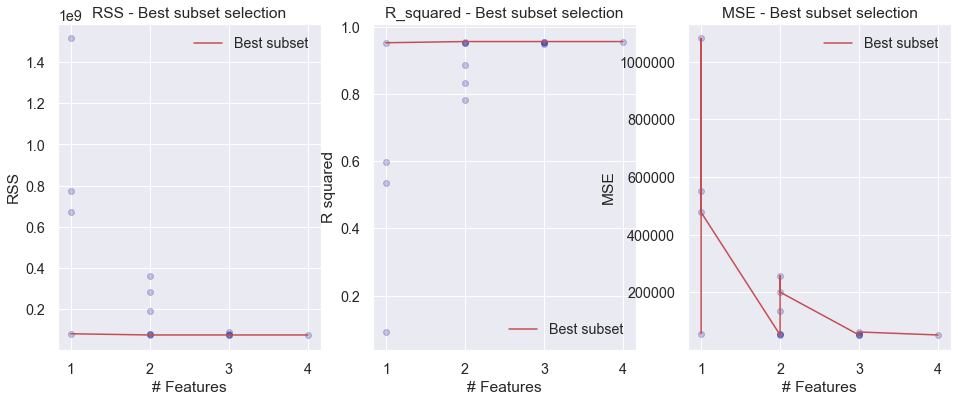

In [15]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df['min_MSE'] = df.groupby('numb_features')['MSE'].transform(min)
df.head()

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 3, 3)
ax.scatter(df.numb_features,df.MSE, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.MSE,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('MSE')
ax.set_title('MSE - Best subset selection')
ax.legend()

plt.show()

Por el criterio "del codo" tomando como base el estadístico MSE tiene sentido tomar 2 variables.

En una primera prueba se van a considerar las variables deuda_publica e ipc ya que minizan el MSE. Se va a implementar el modelo utilizando sklearn:

In [16]:
# Definimos el algoritmo a utilizar
model01_svr = SVR(kernel = 'rbf', C=1000.0, gamma=1.0)
model01_svr.fit(X_train[["deuda_publica", "ipc"]], y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Aplicamos la técnica de Cross Validation sobre los datos de train.

In [17]:
# Cross validation
from sklearn.model_selection import cross_val_score

# Cross Validation
scores = cross_val_score(model01_svr,X_train[["deuda_publica", "ipc"]],y_train,scoring="neg_mean_squared_error",cv=5)

print("Métricas cros_validation:", scores)
print("Train > MSE cross_validation: ", scores.mean())

Métricas cros_validation: [-61520.99568937 -53203.88597923 -63479.03313169 -56575.99172532
 -72826.17962097]
Train > MSE cross_validation:  -61521.21722931477


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [18]:
path_model_save = "./models/svr_fit_ultimo_filter_data_deuda_publica+ipc_python.pkl"  
joblib.dump(model01_svr, path_model_save)

['./models/svr_fit_ultimo_filter_data_deuda_publica+ipc_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [19]:
model01_svr = joblib.load(path_model_save)

Finalmente realizamos las prediciones sobre los datos de test y obtenemos distintos estadísticos para comprobar como de eficiente es nuestro modelo.

In [20]:
y_pred = model01_svr.predict(X_test[["deuda_publica", "ipc"]])

In [21]:
# MAE: Mean absolute error
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, y_pred))
# MSE: Mean squared error
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))
# RMSE: Root mean squared error
print("Root mean squared error: %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# Coeficiente de variación. El mejor puntaje es un 1.0
print("R-Cuadrado: %.2f" % metrics.r2_score(y_test, y_pred))
# Precisión del modelo
print("Precisión del modelo: ", model01_svr.score(X_test[["deuda_publica", "ipc"]], y_pred))

Mean absolute error: 168.05
Mean squared error: 51435.96
Root mean squared error: 226.79
R-Cuadrado: 0.95
Precisión del modelo:  1.0


El valor Multiple R-squared (R2) indica que el modelo calculado explica el 95% de la variablidad presente en la variable respuesta (ultimo) a su promedio es explicado por el modelo de regresión ajustado. Podemos concluir que el modelo lineal es adecuado para describir la relación que existe entre esas variables independientes (deuda_publica e ipc). 

A continuación vamos a mostrar los valores reales frente a los predichos por el modelo:

In [22]:
test_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_vs_pred

,Actual,Predicted
516,9510.2,9464.400177
343,8250.8,8667.200149
574,11034.8,10884.100160
124,11311.7,10879.200149
1265,9518.5,9573.499796
482,9344.9,9331.200139
360,8185.9,8524.500139
825,10104.1,10110.900194
593,10879.7,10759.299654
428,8686.5,8865.199565


Para comparar la variación entre ambos valores de una forma más rápida y visual vamos a plotear los valores:

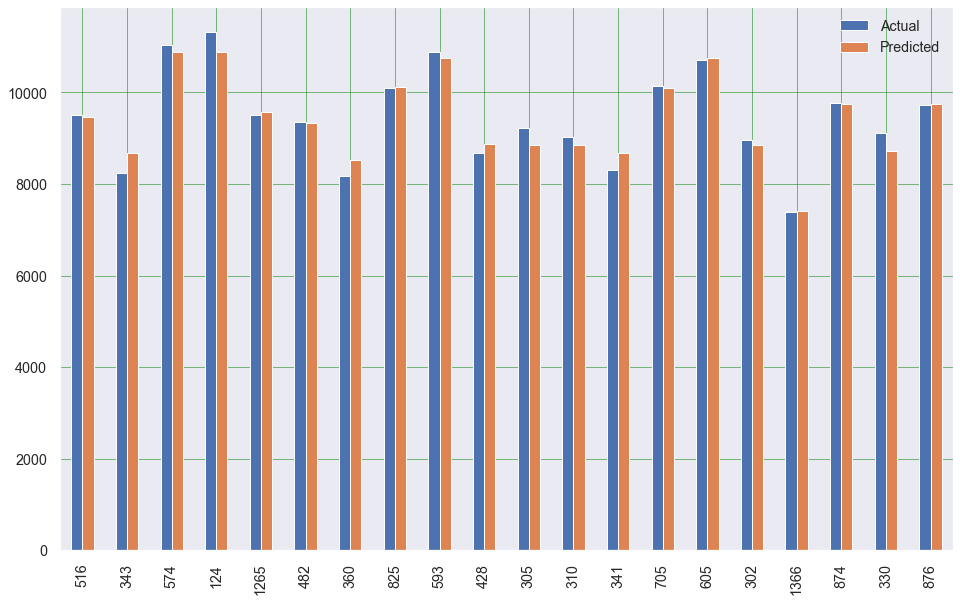

In [23]:
df1 = test_vs_pred.head(40)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Como podemos observar el modelo es aún bastante mejorable.